#Постановка задачи и выяснение общей картины
Представьте, что вы работаете в крупном магазине спортивных товаров. Ваша задача — с помощью данных о покупках клиентов и их социально-демографических признаках проанализировать эффективность уже проведённых ранее маркетинговых кампаний и выявить факторы, способные повысить продажи.

Вам предоставили данные о покупках клиентов за два месяца. Чтобы не возникло утечки, вся информация была зашифрована. Данные хранятся в базе данных (shop_database.db) в data.zip (папка result_data).

База данных содержит три таблицы:

personal_data — ID клиентов, их пол, возраст, образование, страна и город проживания;
personal_data_coeffs — данные с персональными коэффициентами клиентов, которые рассчитываются по некоторой закрытой схеме (вам потребуется коэффициент personal_coef);
purchases — данные о покупках: ID покупателя, название товара, цвет, стоимость, гендерная принадлежность потенциальных покупателей товара, наличие скидки (поле base_sale. Значение 1 соответствует наличию скидки на момент покупки) и дата покупки.

При передаче данных выяснилось, что часть информации о клиентах из таблицы personal_data была утеряна. Поэтому, помимо базы данных, вам предоставили сжатый CSV-файл с утерянными данными (personal_data.csv.gz). К сожалению, информацию о поле клиентов восстановить не удалось. Вам необходимо построить модель классификации на полных данных, чтобы, соответственно, восстановить утерянные.

Известно, что магазин проводил две маркетинговые кампании:

Первая кампания проводилась в период с 5-го по 16-й день, ID участвовавших в ней пользователей содержатся в файле ids_first_company_positive.txt. Эта кампания включала в себя предоставление персональной скидки 5 000 клиентов через email-рассылку.
Вторая кампания проводилась на жителях города 1 134 и представляла собой баннерную рекламу на билбордах: скидка всем каждое 15-е число месяца (15-й и 45-й день в нашем случае).
Заказчик просит вас проанализировать, насколько первая маркетинговая кампания была эффективна. Для проведения A/B-тестирования, помимо людей, которым предлагалась персональная скидка, были отобраны люди со схожими социально-демографическими признаками и покупками, которым скидку не предложили. ID этих клиентов лежат в аналогичном файле ids_first_company_negative.txt. Проведите расчёт A/B-теста и посчитайте значения основных метрик. Потом сделайте бизнес-рекомендацию и обоснуйте её.

Также выясните, на какие кластеры разбивается аудитория, и предложите методы работы с каждым кластером. Обратите внимание, что количество кластеров необходимо выбрать самостоятельно. В итоговом анализе должна содержаться информация о том, какие товары предпочитают различные кластеры клиентов и насколько на покупку влияет наличие скидки. Если работа некоторых методов занимает слишком много времени, рекомендуем взять случайную выборку строк из датасета (например, 100 000 строк) и построить кластеризацию на её основе.

Ещё заказчика интересует информация о жителях страны 32 города 1 188: именно на них планируется запуск новой маркетинговой кампании. Постройте модель склонности клиента к покупке определённого товара при коммуникации, основанную на данных о профилях клиентов, данных товаров и данных о прошлых маркетинговых кампаниях.

In [1]:
# Импорты всех необходимых библиотек
import warnings
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sqlalchemy import create_engine, text
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from kmodes.kprototypes import KPrototypes


## Проводим разведочный анализ данных
Создаем фреймы с данными, проводим базовую чистку (дубликаты, пустые значения, типизация данных, ненужные атрибуты) и слияния данных для дальнейшего использования в моделях машинного обучения.

In [2]:
# подключаем данные из Базы данных
engine = create_engine('sqlite:///shop_database.db')
conn = engine.connect()

In [3]:
# создаем датафрейм с данными о клиентах
df_personas = pd.read_sql(sql=text('SELECT * FROM personal_data'),con=conn)

In [4]:
# создаем датафрейм с данными о персональных коэффициентах клиентов
df_coefs = pd.read_sql(sql=text('SELECT * FROM personal_data_coeffs'),con=conn)

In [5]:
# создаем датафрейм с данными о покупках
df_purchases = pd.read_sql(sql=text('SELECT * FROM purchases'),con=conn)

In [6]:
# создаем датафрейм с утерянными данными
df_lost = pd.read_csv('personal_data.csv.gz', compression='gzip', header=0)

In [7]:
# Объединяем датафреймы с данными о клиентах с утерянными данными
df_clients = pd.concat([df_personas, df_lost])

In [8]:
# Дополняем датафрейм с клиентами признаком с коэффициентами клиентов
df_clients = df_clients.merge(df_coefs[['id', 'personal_coef']], on='id', how='inner')

In [9]:
# проверяем датафрейм на наличие дубликатов - 0 говорит об их отсутсвии
df_clients.duplicated().sum()

0

In [10]:
# Проверяем процент пропущенных значений
((df_clients.isna().sum() / len(df_clients)) * 100).sort_values(ascending=False)

gender           14.999667
id                0.000000
age               0.000000
education         0.000000
city              0.000000
country           0.000000
personal_coef     0.000000
dtype: float64

In [11]:
# Для дальнейшего использования датафрейма нужно избавится от Категориальных признаков, Преобразуем категориальный признак с помощью Label Encoder
le = LabelEncoder()
df_clients['education'] = le.fit_transform(df_clients['education'])

In [12]:
# Для заполнения утерянных данных про пол - разделяем выборку на обучающую и тестовую - и ищем лучший метод
df_train = df_clients[~df_clients['gender'].isna()].dropna()
df_test = df_clients[df_clients['gender'].isna()]
x_train = df_train.drop(columns=['gender','id']) # отбрасываем пол и id
y_train = df_train['gender']
x_test = df_test.drop(columns=['gender','id']) # отбрасываем пол и id
y_test = df_test['gender']
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
# подбираем параметры модели
params = {'n_estimators' : [300, 500, 700],
          'max_depth': np.arange(10, 60, 4),
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2)}
rs = RandomizedSearchCV(rfc, params, cv=skf, scoring='f1', n_jobs=-1, error_score='raise') # для выбора параметров испольуем F-меру
rs.fit(x_train, y_train)
print('Скор наилучший: ', rs.best_score_)
print('Лучшие параметры: ', rs.best_params_)

Скор наилучший:  0.9999022333801678
Лучшие параметры:  {'n_estimators': 500, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_depth': 46}


In [13]:
params = {"loss":["log_loss", "exponential"],
          "learning_rate": [0.01,0.1,1,10,100],
          'max_depth': np.arange(2, 60, 4),
          'max_features': ['sqrt', 'log2', None],
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2),
          "max_features":["log2","sqrt"],
          "criterion": ["friedman_mse",  "squared_error"],
          "subsample":np.arange(0.1, 1, 0.1),
          "n_estimators":[100, 300, 500]}
rscv = RandomizedSearchCV(gbc, params, cv=skf, scoring='f1', n_jobs=-1, error_score='raise')
rscv.fit(x_train, y_train)
print('Скор наилучший: ', rscv.best_score_)
print('Лучшие параметры: ', rscv.best_params_)

Скор наилучший:  0.9999217894572189
Лучшие параметры:  {'subsample': 0.7000000000000001, 'n_estimators': 500, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 54, 'loss': 'log_loss', 'learning_rate': 0.01, 'criterion': 'squared_error'}


In [14]:
# Итого наилучшая модель с лучшим скором - это GBC, обучаем модель и предсказываем пол клиента
model = GradientBoostingClassifier(subsample=0.7, n_estimators=500, min_samples_split=12, min_samples_leaf=9,
                                   max_features='sqrt', max_depth=54, loss= 'exponential', learning_rate=0.01,
                                   criterion='squared_error').fit(x_train, y_train)
df_test['gender'] = model.predict(x_test)

C:\Users\user\AppData\Local\Temp/ipykernel_13908/4091678828.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['gender'] = model.predict(x_test)


In [15]:
header = ["id","gender"]
df_test.to_csv('test.csv',  columns = header, index=False)

In [20]:
# Объединяем датафреймы с данными с полом и без пола - теперь пропусков с данными по полу клиентов в датафрейме нет
df_clients = pd.concat([df_train, df_test])

In [20]:
# проверяем датафрейм на наличие дубликатов - 0 говорит об их отсутсвии
df_purchases.duplicated().sum()

0

In [21]:
# Проверяем процент пропущенных значений
((df_purchases.isna().sum() / len(df_purchases)) * 100).sort_values(ascending=False)

product_sex    40.026454
colour         15.201587
id              0.000000
product         0.000000
cost            0.000000
base_sale       0.000000
dt              0.000000
dtype: float64

In [21]:
# Заполняем пропущенные значения
# из описания товаров
df_purchases['product_sex'] = df_purchases['product_sex'].fillna(2)
# цвет товара заполняем значением 'другой'
df_purchases['colour'] = df_purchases['colour'].fillna('другой')

# разбираемся с данными с е и ё
df_purchases['colour'] = df_purchases['colour'].replace(['чёрный'], 'черный')
# заполняем - в lowercase
df_purchases['product'] = df_purchases['product'].apply(lambda x: " ".join(re.findall('[А-Яа-я]{3,20}', x)).lower())
# оставляем первый цвет в перечне
df_purchases['colour'] = df_purchases['colour'].apply(lambda x: x.split('/')[0].lower())

# Проводим A/B тестирование
Выбираем три метрики для A/B тестирования: 1. средняя выручка 2. средний чек 3. количество покупок

Проверка 1-ой гипотезы:
Основная гипотеза: нет статистически значимой разницы между средней выручкой на одного пользователя в тестовой и контрольной группах.

Альтернативная гипотеза: есть статистически значимая разница между средней выручкой на одного пользователя в тестовой и контрольной группах.

Проверка 2-ой гипотезы:
Основная гипотеза: нет статистически значимой разницы между средним чеком в тестовой и контрольной группах.

Альтернативная гипотеза: есть статистически значимая разница между средним чеком в тестовой и контрольной группах.

Проверка 3-ей гипотезы:
Основная гипотеза: нет статистически значимой разницы между средним количеством купленных товаров в тестовой и контрольной группах.

Альтернативная гипотеза: есть статистически значимая разница между средним количеством купленных товаров в тестовой и контрольной группах.

In [24]:
# Загружаем файлы которые содержат id клиентов участвовавших в A/B тесте
with open('ids_first_company_positive.txt') as f:
    positive = f.read()
elem_list = re.split(';|,| ', positive)
positive_id = []
for i in elem_list:
    if i.isdigit():
        positive_id.append(int(i))
with open('ids_first_company_negative.txt') as f:
    negative = f.read()
elem_list = re.split(';|,| ', negative)
negative_id = []
for i in elem_list:
    if i.isdigit():
        negative_id.append(int(i))
# В тестовую группу берем покупки которые были совершены во время проведения первой рекламной компании
df_test = df_purchases[(df_purchases['dt'] >= 5) & (df_purchases['dt'] < 17)]
# Получаем значение выручки на одного клиента
arpu_group1 = df_test.groupby('id', as_index=False).agg({'cost':'sum'})
# Создаем датафрейм с клиентами со скидками по рекламной компании
positive_arpu = arpu_group1.loc[arpu_group1['id'].isin(positive_id), :]
# Создаем датафрейм с клиентами без скидок
negative_arpu = arpu_group1.loc[arpu_group1['id'].isin(negative_id), :]

In [25]:
# С помощью теста шапиро проверяем нормальности распределения - раз статистики велики, то распеределние не нормальное
print(stats.shapiro(positive_arpu['cost']))
print(stats.shapiro(negative_arpu['cost']))

ShapiroResult(statistic=0.5344901084899902, pvalue=0.0)
ShapiroResult(statistic=0.47260046005249023, pvalue=0.0)


In [26]:
# распределение не нормальное,
# выборки независимы,
# используем критерий Манна-Уитни для проверки гипотезы о среднем
mann = stats.mannwhitneyu(positive_arpu['cost'], negative_arpu['cost'])
print(mann)
if mann[1] < 0.05:
    print('статистически значимая разница есть')
else:
    print('статистически значимой разницы нет')

MannwhitneyuResult(statistic=13632883.5, pvalue=3.977397095679975e-40)
статистически значимая разница есть


<ipython-input-27-e6b6764b39f1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_arpu['cost'].mean(),


<ErrorbarContainer object of 3 artists>

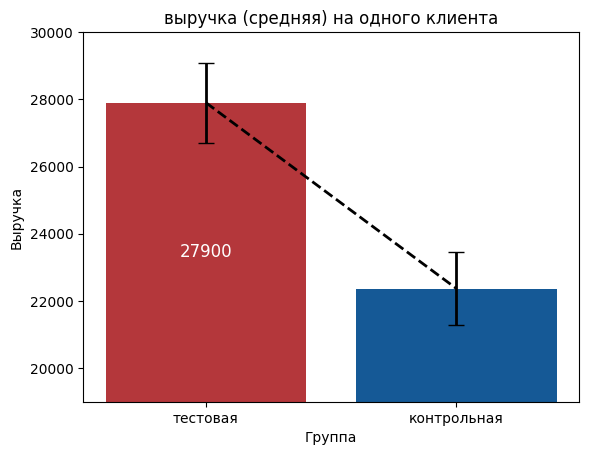

In [27]:
std_error_test= np.std(positive_arpu['cost']) / np.sqrt(len(positive_arpu['cost']))
std_error_control = np.std(negative_arpu['cost']) / np.sqrt(len(negative_arpu['cost']))
fig,ax = plt.subplots()
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_arpu['cost'].mean(),
                                                  negative_arpu['cost'].mean()],
                                                  palette=['#C92228','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.0f')
ax.set_title('выручка (средняя) на одного клиента')
ax.set(xlabel='Группа', ylabel='Выручка',  ylim=(19000, 30000))
ax.errorbar(x = ['тестовая', 'контрольная'], y = [positive_arpu['cost'].mean(),
                                                  negative_arpu['cost'].mean()],
                                                  yerr = [1.96*std_error_test, 1.96*std_error_control],
                                                  fmt='--k', linewidth=2, capsize=6, ecolor= 'black')

In [28]:
# получаем условный средний чек по клиентам.
bill_group = df_test.groupby(['dt','id'], as_index=False).agg({'cost':'sum'})
positive_bill = bill_group.loc[bill_group['id'].isin(positive_id), :]
negative_bill = bill_group.loc[bill_group['id'].isin(negative_id), :]
# проверяем нормальности распределения - раз статистики велики, то распеределние не нормальное
print(stats.kstest(positive_bill['cost'], "norm"))
print(stats.kstest(negative_bill['cost'], "norm"))

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=12, statistic_sign=-1)
KstestResult(statistic=1.0, pvalue=0.0, statistic_location=39, statistic_sign=-1)


In [29]:
# распределение не нормальное,
# выборки независимы,
# используем критерий Манна-Уитни для проверки гипотезы
mann = stats.mannwhitneyu(positive_bill['cost'], negative_bill['cost'])
print(mann)
if mann[1] < 0.05:
    print('статистически значимая разница есть')
else:
    print('статистически значимой разницы нет')

MannwhitneyuResult(statistic=72554564.5, pvalue=7.639013623733095e-11)
статистически значимая разница есть


<ipython-input-32-d26c0306bfd2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_bill['cost'].mean(),


<ErrorbarContainer object of 3 artists>

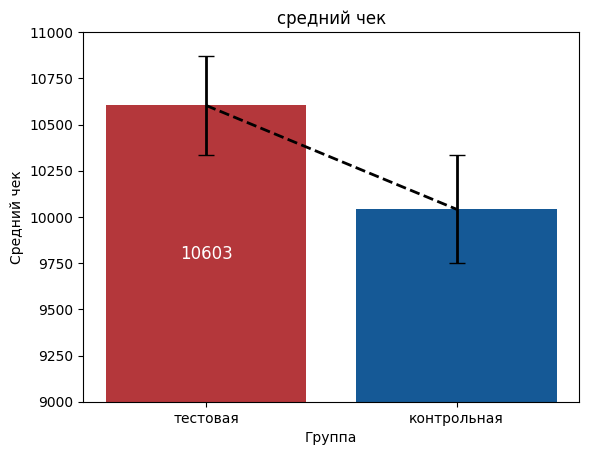

In [32]:
std_error_test= np.std(positive_bill['cost']) / np.sqrt(len(positive_bill['cost']))
std_error_control = np.std(negative_bill['cost']) / np.sqrt(len(negative_bill['cost']))

fig,ax = plt.subplots()
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_bill['cost'].mean(),
                                                  negative_bill['cost'].mean()],
                                                  palette=['#C92228','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.0f')
ax.set_title('средний чек')
ax.set(xlabel='Группа', ylabel='Средний чек', ylim=(9000, 11000))
ax.errorbar(x = ['тестовая', 'контрольная'], y = [positive_bill['cost'].mean(),
                                                  negative_bill['cost'].mean()],
                                                  yerr = [1.96*std_error_test, 1.96*std_error_control],
                                                  fmt='--k', linewidth=2, capsize=6, ecolor= 'black')

In [33]:
# группируем данные по количеству покупок на 1 клиента
count_group = df_test.groupby(['id'], as_index=False).agg({'cost':'count'})
positive_сount = count_group.loc[count_group['id'].isin(positive_id), :]
negative_сount = count_group.loc[count_group['id'].isin(negative_id), :]
# проверяем нормальность распределения - если показатели велики, то распределения не нормальны
print(stats.kstest(positive_сount['cost'], "norm"))
print(stats.kstest(negative_сount['cost'], "norm"))

KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)
KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)


In [34]:
# распределение не нормальное,
# выборки независимы,
# используем критерий Манна-Уитни для проверки гипотезы
mann = stats.mannwhitneyu(positive_сount['cost'], negative_сount['cost'])
print(mann)
if mann[1] < 0.05:
    print('статистически значимая разница есть')
else:
    print('статистически значимой разницы нет')

MannwhitneyuResult(statistic=14503562.5, pvalue=4.042645528365477e-87)
статистически значимая разница есть


<ipython-input-35-e57299be7d61>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_сount['cost'].mean(),


<ErrorbarContainer object of 3 artists>

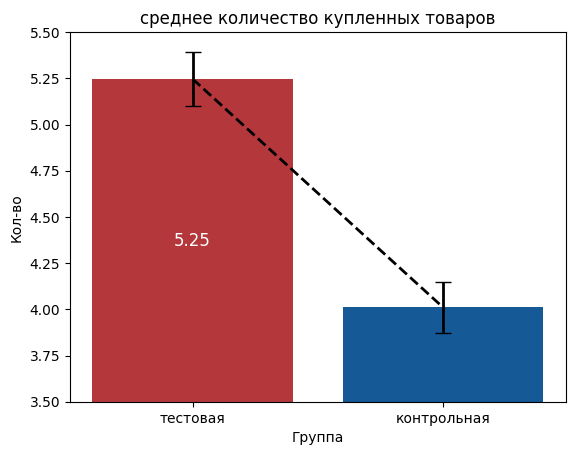

In [35]:
std_error_test= np.std(positive_сount['cost']) / np.sqrt(len(positive_сount['cost']))
std_error_control = np.std(negative_сount['cost']) / np.sqrt(len(negative_сount['cost']))

fig,ax = plt.subplots()
sns.barplot(x = ['тестовая', 'контрольная'], y = [positive_сount['cost'].mean(),
                                                  negative_сount['cost'].mean()],
                                                  palette=['#C92228','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.2f')
ax.set_title('среднее количество купленных товаров')
ax.set(xlabel='Группа', ylabel='Кол-во', ylim=(3.5, 5.5))

ax.errorbar(x = ['тестовая', 'контрольная'], y = [positive_сount['cost'].mean(),
                                                  negative_сount['cost'].mean()],
                                                  yerr = [1.96*std_error_test, 1.96*std_error_control],
                                                  fmt='--k', linewidth=2, capsize=6, ecolor= 'black')

# Вывод по A/B тестированию
По результатам проведения тестирвания выявлена значимая разница во всех трех показателях, выбранных для оценки эффективности A/B тестирвоания в расчете на одного клиента - средняя выручка в тестовой группе выше на 25%, средний чек выше на 6%, среднее количество купленных товаров  выше на 31%.

 Можно сделать вывод, что маркетинговая компания была эффективна.
 Рекомендации - продолжать данную маркетинговую компанию.

# Проверка на какие кластеры разбивается аудитория.

In [22]:
# Создаем новую таблицу с группировкой по клиентам и аггрегациями
df_group = df_purchases.groupby('id', as_index=False).agg({'cost':'sum',
                                                   'product': pd.Series.mode,
                                                   'colour': pd.Series.mode,
                                                   'product_sex': pd.Series.mode,
                                                   'base_sale':'mean',
                                                   'dt':'max'
                                                   })

In [23]:
# Переименовываем признаки согласно смысловому наполнению
dict = {'cost': 'cost_sum',
        'product': 'product_mode',
        'colour': 'color_mode',
        'product_sex': 'product_sex_mode',
        'base_sale': 'best_sale_mean',
        'dt': 'dt_max'}
df_group = df_group.rename(columns=dict)

In [24]:
# признаки - списки преобразуем в строки
mode_columns = ['product_mode', 'color_mode', 'product_sex_mode']

for column in mode_columns:
    df_group[column] = df_group[column].apply(lambda x: x[0] if type(x) == np.ndarray else x)

In [25]:
# Объединяем датафрейм с клиентским клиентах
df = pd.merge(left=df_clients, right=df_group, on='id', how='inner')

In [26]:
# избавляемся от полей, которые не являются значимыми для модуля
df = df.drop(columns=['id'])

In [27]:
# избавляемся от разных масштабов в атррибутах
num_columns = ['age', 'personal_coef','cost_sum', 'best_sale_mean','dt_max']
scaler = StandardScaler()
df[num_columns] = scaler.fit_transform(df[num_columns])

In [42]:
#  ищем оптимальное количество кластеров с помощью метода локтя - метод поменял - для ускорения
n_clusters = list(range(2,8))
cost = []
for n in n_clusters:
    kproto = KPrototypes(n_clusters=n, init='Cao', n_jobs=-1)
    kproto.fit_predict(df, categorical=[0,2,3,4,7,8,9])
    cost.append(kproto.cost_)

KeyboardInterrupt: 

In [52]:
#df = df.drop(["color_mode", "product_mode"], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

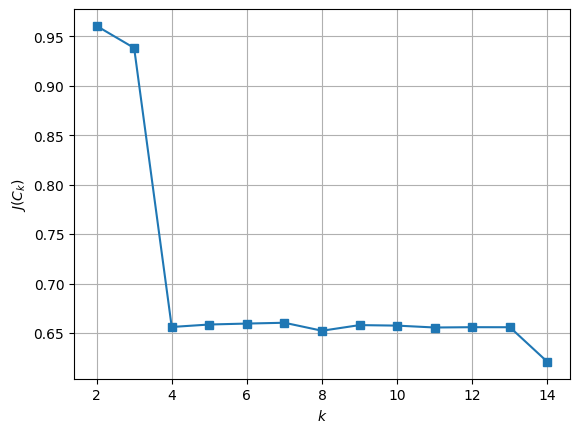

In [55]:
#from sklearn.cluster import AgglomerativeClustering, KMeans
#from sklearn.metrics import silhouette_score
#inertia = []
#silhouette = []
#N = 15
#for k in range(2, N):
#    kmeans = KMeans(n_clusters=k, random_state=1).fit(df)
#    preds = kmeans.predict(df)
#    inertia.append(np.sqrt(kmeans.inertia_))
#    silhouette.append(silhouette_score(df, preds))
#plt.plot(range(2, N), silhouette, marker='s');
#plt.xlabel('$k$')
#plt.grid()
#plt.ylabel('$J(C_k)$');

In [30]:
df = df.drop(["color_mode", "product_mode"], axis=1)

In [31]:
df

,gender,age,education,city,country,personal_coef,cost_sum,product_sex_mode,best_sale_mean,dt_max
0,0.0,-0.164185,1,1201,32,0.780515,-0.273267,2.0,0.018147,-0.263520
1,0.0,-0.245598,1,1134,32,0.780515,-0.124694,2.0,-1.196488,-0.610717
2,1.0,1.138417,1,1188,32,-0.446917,0.578515,1.0,0.261074,-0.749595
3,0.0,-0.082773,1,1198,32,0.780515,0.243339,2.0,0.205014,0.569751
4,0.0,0.812766,1,1134,32,0.780515,0.302563,0.0,2.083027,1.055825
...,...,...,...,...,...,...,...,...,...,...
104984,1.0,0.487116,1,1134,32,-0.446917,0.156512,0.0,0.018147,1.125265
104985,1.0,0.649941,1,1134,32,-0.446917,-0.254994,1.0,-1.196488,0.847508
104986,0.0,2.685256,1,1134,32,0.780515,-0.368440,0.0,0.261074,-1.027352
104987,1.0,-0.489836,1,1188,32,-0.446917,1.035139,1.0,-0.467707,-1.235670


In [32]:
# итого кол-во кластеров 4 - проводим обучение модели кластеризации - выбрал только категориальные аттрибуты
kproto = KPrototypes(n_clusters=4, init='Cao', n_jobs=-1)
kproto.fit_predict(df, categorical=[0,2,3,4,5,6])

array([2, 0, 0, ..., 3, 0, 2], dtype=uint16)

In [33]:
# числовые признаки преобразуем для визуализации
tsne = TSNE(n_components=2, perplexity=40)
df_emb = tsne.fit_transform(df[num_columns])
data = pd.DataFrame(df_emb)

<Axes: xlabel='0', ylabel='1'>

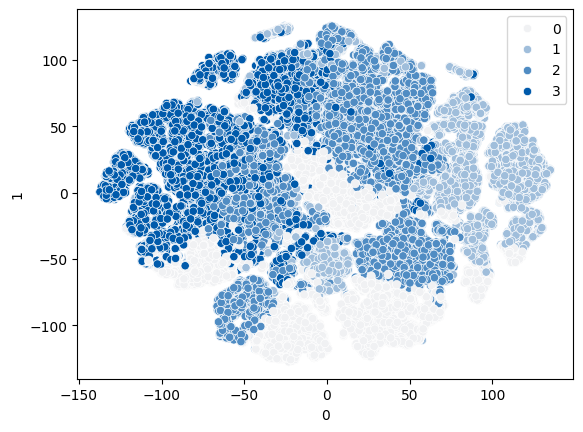

In [34]:
pallete = sns.color_palette("light:#005AAB", as_cmap=True)
sns.scatterplot(x=data[0], y=data[1], hue=kproto.labels_, palette=pallete)

In [35]:
# обратно преобразуем признаки, для интерпритации
df[num_columns] = scaler.inverse_transform(df[num_columns])
num_columns.extend(['education','gender'])
mode_cols = set(df.columns) - set(num_columns)
d1 = dict.fromkeys(num_columns, 'mean')
d2 = dict.fromkeys(mode_cols, pd.Series.mode)

In [36]:
d = {**d1, **d2}
df_g1 = df.groupby(kproto.labels_, as_index=False).agg(d)
df_g1 = df_g1.round(2).T
df_g1 = df_g1.rename(columns={0:'cluster 1', 1:'cluster 2', 2:'cluster 3', 3:'cluster 4'})
df_g1

,cluster 1,cluster 2,cluster 3,cluster 4
age,39.24,21.20,42.91,42.83
personal_coef,0.46,0.42,0.46,0.49
cost_sum,28269.99,43225.42,53680.73,32208.77
best_sale_mean,0.15,0.35,0.21,0.61
dt_max,21.59,43.10,50.00,43.64
education,0.87,0.15,0.96,0.94
gender,0.63,0.72,0.69,0.27
city,1134.00,1134.00,1134.00,1134.00
country,32.00,32.00,32.00,32.00
product_sex_mode,2.00,1.00,2.00,0.00


#Выводы:
Клиентская база разбивается на следующие 4 кластера:

1.	6%, Это возрастная группа (средний возраст 39 лет), это в основном мужчины (63%) со среднем образованием (13%) покупают без скидок (15%) минимальным средней суммой расходов (28 тысяч рублей) и очень часто (21 день с даты последней покупки).

2.	30%, Это молодежь (средний возраст 21 год), и имеют в основном высшее образование (85%). В основном мужчины (72%). Средняя сумма расходов на одного клиента (43 тысяч рублей).

3.	26%, Это возрастная группа (42 года) редко покупают (50 дней с последней покупки), среднее образование (4%), средние расходы самые высокие (53 тысячи рублей)

4.	38%, в основном женщины (73%), среднее образование (6%), покупают все по скидкам (61%) и средние расходы (32 тысячи рублей)


# Модель склонности клиента к покупке товара

In [67]:
# Повторяем загрузку данных для анализа
with open('ids_first_company_positive.txt') as f:
    positive = f.read()
elem_list = re.split(';|,| ', positive)
positive_id = []
for i in elem_list:
    if i.isdigit():
        positive_id.append(int(i))
# берем клиентов которые были в первой маркетинговой компании
df_first = df_purchases[(df_purchases['dt'] >= 5) & (df_purchases['dt'] < 17)]
product_group = df_first.groupby('id', as_index=False).agg({'product': pd.Series.mode})
first_camp = product_group.loc[product_group['id'].isin(positive_id), :]
first_camp['product'] = first_camp['product'].apply(lambda x: x[0] if type(x) == np.ndarray else x)
# берем клиентов которые были во второй маркетинговой компании
df_second = df_purchases[(df_purchases['dt'] == 15) | (df_purchases['dt'] == 45)]
second_camp = df_second.groupby('id', as_index=False).agg({'product': pd.Series.mode})
second_camp['product'] = second_camp['product'].apply(lambda x: x[0] if type(x) == np.ndarray else x)
# объединяем датафреймы по покупкам и первой маркетинговой компании
first_df = pd.merge(left=df_clients, right = first_camp, on='id', how='inner')
second_df = pd.merge(left=df_clients, right = second_camp, on='id', how='inner')
second_df = second_df[second_df.city == 1134]
train = first_df.merge(second_df)
train.drop_duplicates() # сбрасываем дубли
# упрощаем название товаров
train['product'] = train['product'].apply(lambda x: x.split(' ')[0])
# формируем тестовый датафрейм на котором необходимо применить модель (о жителях страны 32 города 1 188)
test = df_clients[(df_clients.city == 1188) & (df_clients.country == 32)]
x_train = train.drop(columns=['id', 'product'])
y_train = train['product']
x_test = test.drop(columns=['id'])
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rfc = RandomForestClassifier()
# ищем наилучшие гиперпараметры модели
params = {'n_estimators' : [300, 500, 700],
          'max_depth': np.arange(10, 60, 4),
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2),
          'class_weight': ('balanced', None)}
rs = RandomizedSearchCV(rfc, params, cv=skf, scoring='f1_micro', n_jobs=-1, error_score='raise') # по F-мере
rs.fit(x_train, y_train)
print('Лучший скор: ', rs.best_score_)
print('Лучшие параметры: ', rs.best_params_)

<ipython-input-67-7b4e65fdbb1a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_camp['product'] = first_camp['product'].apply(lambda x: x[0] if type(x) == np.ndarray else x)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Лучший скор:  0.11809923130677846
Лучшие параметры:  {'n_estimators': 500, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_depth': 18, 'class_weight': None}


In [68]:
# Выбираем модель RFC с лучшими гиперпараметрами
model = RandomForestClassifier(n_estimators=500, min_samples_split=18, min_samples_leaf=7, max_depth=18, class_weight=None)
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=18, min_samples_leaf=7, min_samples_split=18,
                       n_estimators=500)

In [69]:
model_pred = model.predict(x_test)
x_test['product'] = model_pred
x_test['product'].value_counts()

product
кроссовки    11346
кеды           519
бейсболка      378
брюки          195
Name: count, dtype: int64

# Вывод:
С помощью модели случайного леса с результатом f1-score 17% на обучающей выборке был проведен поиск склонности клиентов по покупке определенных товаров.

После применения модели на тестовой выборке были получены следующие результаты по стране 32 городу 1188:
кроссовки    11346
кеды           519
бейсболка      378
брюки          195